In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
#read in csv's
#census = pd.read_csv('census.csv')
txdata = pd.read_csv('TX_DEA_data.csv')
fips_tx = pd.read_csv("TX_fips.csv", header = None)

In [3]:
#rename columns
txdata = txdata.rename(columns={ "BUYER_COUNTY" : "County" })
#modify county names to match the census data
txdata["County"] = txdata["County"].str.title()
txdata["County"] = txdata["County"] + (" County")
fips_tx.head()

,0,1,2,3,4,5,6
0,"Anderson County, Texas",48001,58084.0,18623.0,0.064217,5760.0,532.0
1,"Andrews County, Texas",48003,16126.0,29363.0,0.046075,3700.0,260.0
2,"Angelina County, Texas",48005,87433.0,21521.0,0.081342,8822.0,1375.0
3,"Aransas County, Texas",48007,23889.0,25906.0,0.092888,2832.0,573.0
4,"Archer County, Texas",48009,8853.0,28250.0,0.045747,1180.0,142.0


In [18]:
#rename columns and modify county name
fips_tx = fips_tx.rename(columns={ 0 : "County", 1 : "fips", 2:'Population', 3:'Avg. Income', 4:'Poverty %', 5:'Construction Jobs',6:'STEM Jobs'})
fips_tx["County"] = fips_tx["County"].str.split(pat = ",", n=1, expand=True)
fips_tx.to_csv('tx_census_data.csv')

In [6]:
#merge census and DEA data
merge_df = txdata.merge(fips_tx, how='left', on='County')
merge_df = merge_df.dropna()
merge_df.head()

,REPORTER_NAME,BUYER_NAME,BUYER_ADDRESS1,BUYER_STATE,County,BUYER_ZIP,TRANSACTION_DATE,CALC_BASE_WT_IN_GM,DRUG_NAME,QUANTITY,DOSAGE_UNIT,dos_str,fips,Population,Avg. Income,Poverty %,Construction Jobs,STEM Jobs
0,BELLCO DRUG CORP,LONGHORN DRUG CO,1711 S. HENDERSON BLVD.,TX,Gregg County,75662,1112006,1.5135,HYDROCODONE,1.0,500.0,5.0,48183.0,122736.0,24137.0,0.080066,13274.0,3336.0
1,BELLCO DRUG CORP,MALLEY'S PHARMACY,MALLEY JOE DAVID,TX,Jefferson County,77706,1042006,1.5135,HYDROCODONE,1.0,500.0,5.0,48245.0,252466.0,23563.0,0.085085,26594.0,6472.0
2,BELLCO DRUG CORP,MALLEY'S PHARMACY,MALLEY JOE DAVID,TX,Jefferson County,77706,11022006,2.4216,HYDROCODONE,4.0,400.0,10.0,48245.0,252466.0,23563.0,0.085085,26594.0,6472.0
3,BELLCO DRUG CORP,MALLEY'S PHARMACY,MALLEY JOE DAVID,TX,Jefferson County,77706,1042007,0.6054,HYDROCODONE,1.0,100.0,10.0,48245.0,252466.0,23563.0,0.085085,26594.0,6472.0
4,BELLCO DRUG CORP,MALLEY'S PHARMACY,MALLEY JOE DAVID,TX,Jefferson County,77706,2142007,0.6054,HYDROCODONE,1.0,100.0,10.0,48245.0,252466.0,23563.0,0.085085,26594.0,6472.0


In [7]:
#group variables by county
quantity = merge_df.groupby("County")["QUANTITY"].sum()
income = merge_df.groupby("County")["Avg. Income"].mean()
pop = merge_df.groupby("County")["Population"].first()
pov = merge_df.groupby("County")["Poverty %"].first()
con = merge_df.groupby("County")["Construction Jobs"].first()
stem = merge_df.groupby("County")["STEM Jobs"].first()

In [8]:
#add groups to dataframes
pop = pop.to_frame()
income = income.to_frame()
quantity = quantity.to_frame()
pov = pov.to_frame()
con = con.to_frame()
stem = stem.to_frame()

In [9]:
#merge dataframes
pmerge = pop.merge(income, how='left', on='County')
tmerge = pmerge.merge(pov, how='left', on='County')
cmerge = tmerge.merge(con, how='left', on='County')
smerge = cmerge.merge(stem, how ='left', on='County')
qmerge = smerge.merge(quantity, how='left', on='County')

#calculate per capita columns
qmerge['Per Cap. Quant.'] = qmerge['QUANTITY'] / qmerge['Population']
qmerge['Construction per Cap.'] = qmerge['Construction Jobs'] / qmerge['Population']
qmerge['STEM per Cap.'] = qmerge['STEM Jobs'] / qmerge['Population']

#sort
qmerge.sort_values(by=['Per Cap. Quant.'], inplace=True, ascending=False)

#rest index and save
qmerge.reset_index()
qmerge.to_csv('tx_data_js.csv')

qmerge.head(3)

,Population,Avg. Income,Poverty %,Construction Jobs,STEM Jobs,QUANTITY,Per Cap. Quant.,Construction per Cap.,STEM per Cap.
County,,,,,,,,,
Young County,18374.0,25859.0,0.075161,2680.0,199.0,48525.0,2.640960,0.145858,0.010831
Stephens County,9485.0,21145.0,0.078651,1356.0,105.0,24449.0,2.577649,0.142963,0.011070
Childress County,7066.0,20982.0,0.065384,418.0,102.0,18169.0,2.571327,0.059157,0.014435


In [10]:
#remove outliers
qmerge = qmerge[(np.abs(stats.zscore(qmerge)) < 3).all(axis=1)]

In [80]:
#get stats
#qmerge = qmerge.drop(['level_0', 'index'], axis=1)
qmerge[['QUANTITY', 'Per Cap. Quant.']].describe()

,QUANTITY,Per Cap. Quant.
count,216.000000,216.000000
mean,52144.935185,0.942449
std,86804.046543,0.556415
min,2.000000,0.000339
25%,4289.500000,0.518079
50%,18215.000000,0.872743
75%,58550.250000,1.298564
max,510411.000000,2.577649


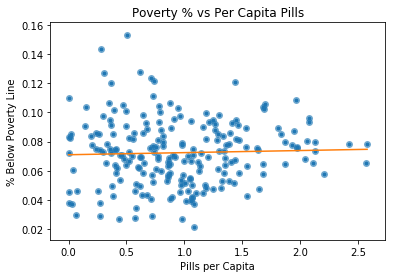

In [95]:
#plot poverty % vs pills per person
y = qmerge['Poverty %']
x = qmerge['Per Cap. Quant.']
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Pills per Capita')
plt.ylabel('% Below Poverty Line')
plt.title('Poverty % vs Per Capita Pills')
plt.savefig('pov.png')
plt.show()

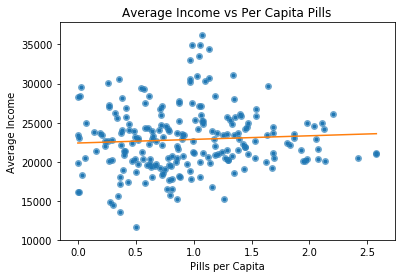

In [97]:
#plot poverty % vs pills per person
y = qmerge['Avg. Income']
x = qmerge['Per Cap. Quant.']
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Pills per Capita')
plt.ylabel('Average Income')
plt.title('Average Income vs Per Capita Pills')
plt.savefig('inc.png')
plt.show()

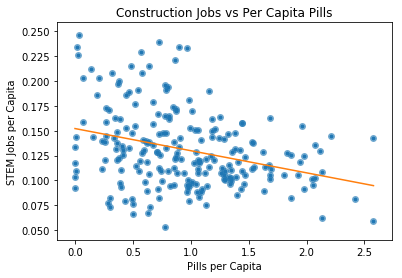

In [89]:
#plot construction jobs per capita vs pills per person
y = qmerge['Construction per Cap.']
x = qmerge['Per Cap. Quant.']
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Pills per Capita')
plt.ylabel('STEM Jobs per Capita')
plt.title('Construction Jobs vs Per Capita Pills')
plt.savefig('const.png')
plt.show()

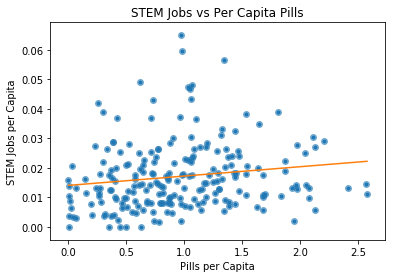

In [90]:
#plot construction jobs per capita vs pills per person
y = qmerge['STEM per Cap.']
x = qmerge['Per Cap. Quant.']
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Pills per Capita')
plt.ylabel('STEM Jobs per Capita')
plt.title('STEM Jobs vs Per Capita Pills')
plt.savefig('stem.png')
plt.show()

In [13]:
#define function to calculate correlation coefficient 
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

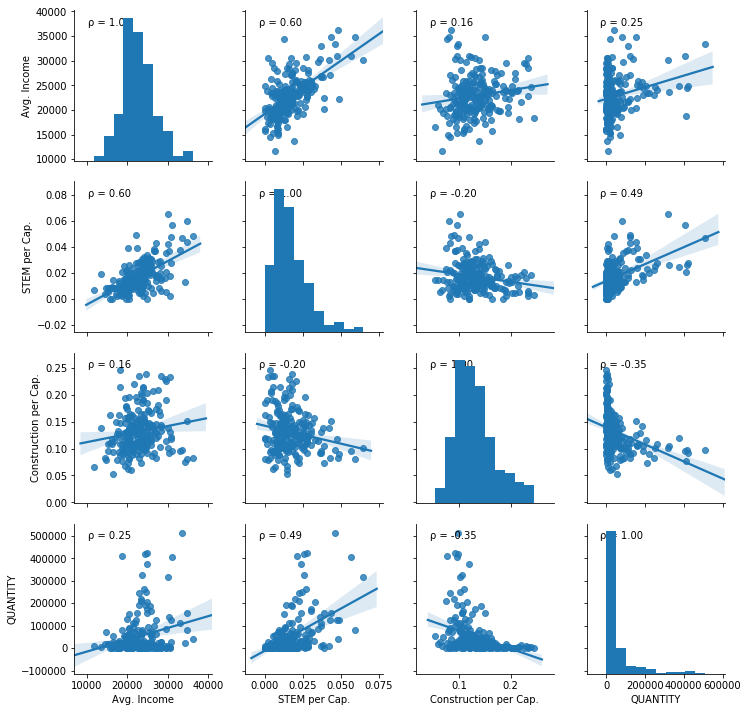

In [16]:
#create dataframe to show in pairplot
correlation_df = qmerge[['Avg. Income', 'STEM per Cap.', 'Construction per Cap.', 'QUANTITY']]

#create pairplot and add correlation coefficients
g = sns.pairplot(correlation_df, kind="reg")
g.map(corrfunc)
plt.savefig('correlation_matrix')
plt.show()



In [93]:
#qmerge = qmerge.reset_index()
lmerge = qmerge.nlargest(15, 'Per Cap. Quant.')
smerge = qmerge.nsmallest(15, 'Per Cap. Quant.')
mmerge = qmerge.loc[111:121]
lmerge = lmerge.append(smerge)
lmerge = lmerge.append(mmerge)
lmerge = lmerge.sort_values('Per Cap. Quant.')
lmerge.head(3)


,County,Population,Avg. Income,Poverty %,Construction Jobs,STEM Jobs,QUANTITY,Per Cap. Quant.,Construction per Cap.,STEM per Cap.
215,Archer County,8853.0,28250.0,0.045747,1180.0,142.0,3.0,0.000339,0.133288,0.016040
214,Real County,3365.0,19806.0,0.082912,312.0,13.0,2.0,0.000594,0.092719,0.003863
213,Culberson County,2325.0,16120.0,0.109677,274.0,0.0,3.0,0.001290,0.117849,0.000000


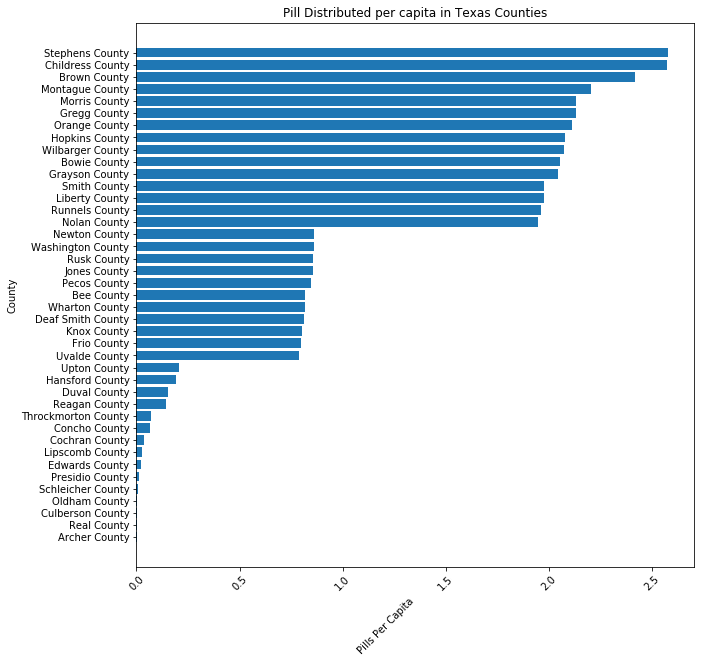

In [94]:
f, ax = plt.subplots(figsize=(10,10))
plt.barh(lmerge['County'], lmerge['Per Cap. Quant.'])
plt.xlabel("Pills Per Capita",rotation=45, horizontalalignment='right')
plt.ylabel("County")
plt.title("Pill Distributed per capita in Texas Counties")
plt.xticks(rotation=45)
plt.savefig('per_cap_quant_bar')



